In [1]:
using Distributions
using PyPlot
using VinDsl
# include("lognormal.jl")
import VinDsl.value
srand(12345);

Set up some parameters

In [2]:
K = 3  # number of latent states
M = 2  # number of values of each latent state
T = 100  # number of time steps
U = 10  # units

10

# Make firing rates

In [3]:
baseline = 10.
baseline_sd = 0.10
log_bl = log(baseline)
unit_bl = log_bl + baseline_sd * randn(U);

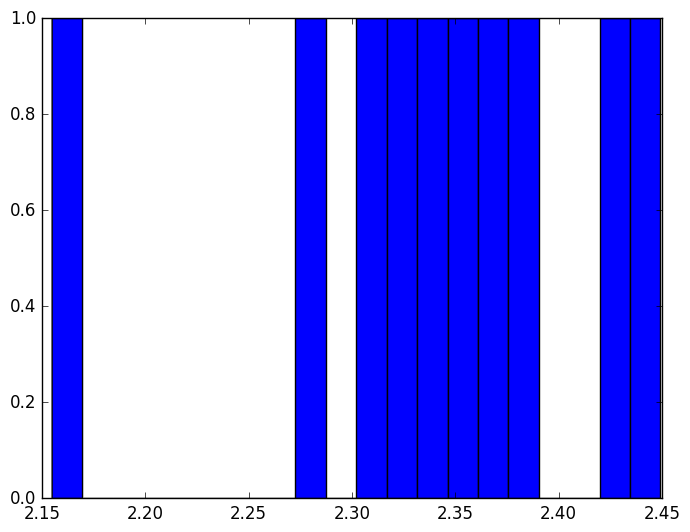

In [4]:
PyPlot.plt[:hist](unit_bl, 20);

In [5]:
fr_log = unit_bl' .+ zeros(T, U)
eta = fr_log + 0.001 * ones(size(fr_log)...)
fr = exp(eta);

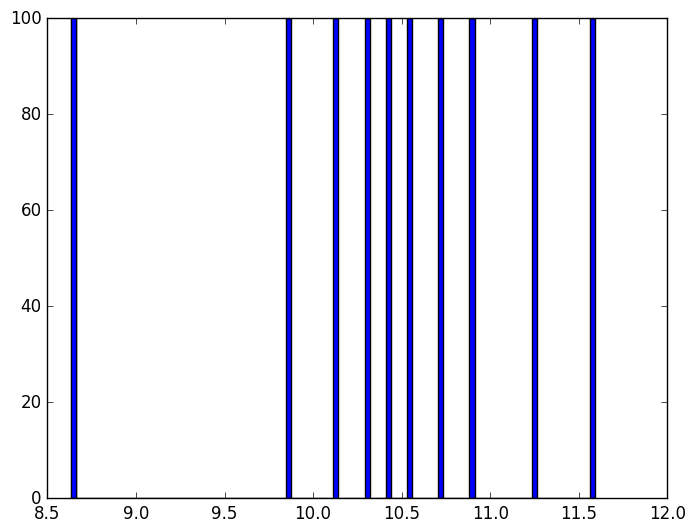

In [6]:
PyPlot.plt[:hist](fr[:], 100);

# Make spikes

In [7]:
spikes = Array{Int}(size(fr)...)
for i in eachindex(fr)
    spikes[i] = rand(Poisson(fr[i]))
end

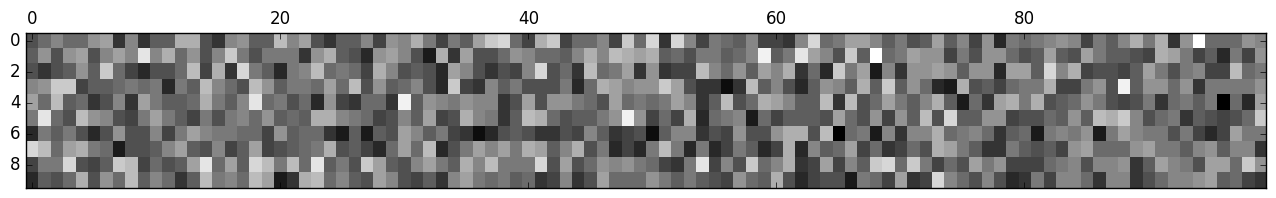

PyObject <matplotlib.image.AxesImage object at 0x7efc35d1bc90>

In [8]:
matshow(spikes', aspect="auto", cmap="gray")

# Initialize priors

## Baseline

In [9]:
μ_a = log(15.)
σ_a = 0.1
τ_a = 1/σ_a^2
a_prior = NormalCanon(μ_a * τ_a, τ_a)

Distributions.NormalCanon{Float64,Float64}(η=270.805020110221, λ=99.99999999999999, μ=2.7080502011022105)

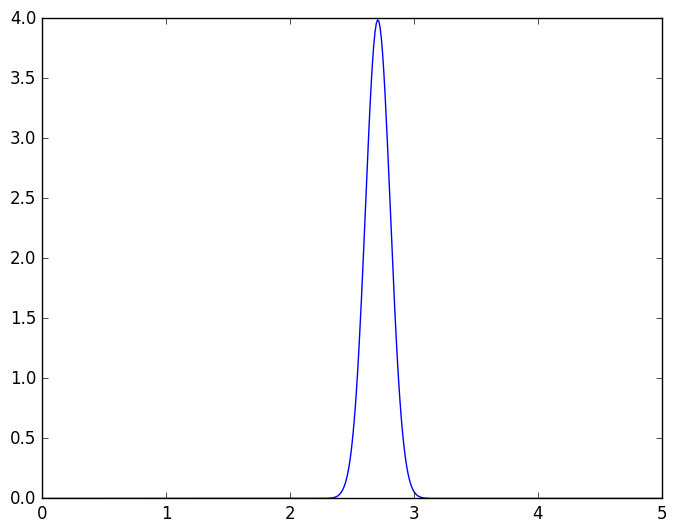

In [10]:
xx = linspace(0, 5, 500)
plot(xx, pdf(a_prior, xx));

## Noise

In [11]:
τ_prior = Gamma(2, 1/20)

Distributions.Gamma{Float64}(α=2.0, θ=0.05)

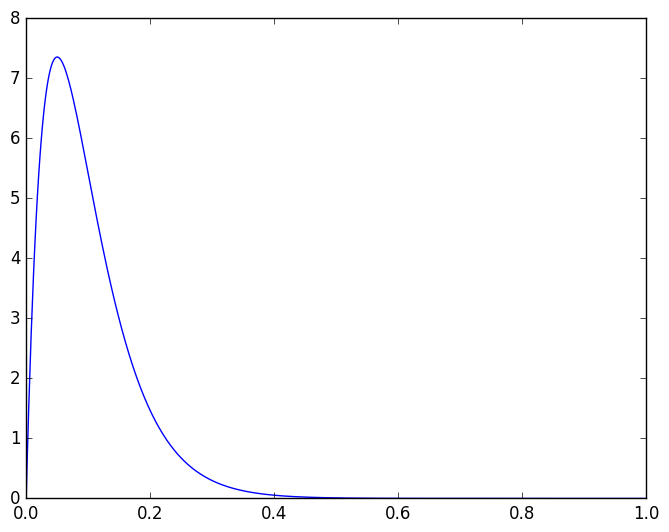

In [12]:
xx = linspace(0, 1, 500)
plot(xx, pdf(τ_prior, xx));

# Make VinDsl model

We want to make the model

$$\begin{align}
N_{tu} &\sim \mathrm{Poisson}(e^{\eta_{tu}}) \\
\eta_{tu} &\sim \mathcal{N}(a_u, \tau_\eta) \\
a_u &\sim \mathcal{N}(m_a, t_a) \\
\tau_\eta &\sim \mathrm{Gamma}(s_\tau, l_\tau)
\end{align}$$

To do this, we first need to define a factor for the Poisson distribution parameterized in terms of log firing rate:

In [13]:
@deffactor LogPoissonAltFactor [n, x] begin
    E(n) * E(x) - lgamma(E(n) + 1) - mgf(x, 1)
end

value (generic function with 11 methods)

Now let's define a posterior model:

$$\begin{align}
\eta_{tu} &\sim \mathcal{N}((\mu_\eta)_{tu}, (\sigma_\eta)_{tu}) \\
a_u &\sim \mathcal{N}((\mu_a)_u, (\sigma_a)_u) \\
\tau_\eta &\sim \mathrm{Gamma}(\alpha_\tau, \theta_\tau)
\end{align}$$

In [14]:
n[t, u] ~ Const(spikes)
η[t, u] ~ Normal(zeros(T, U), 0.5 * ones(T, U))
a[u] ~ Normal(zeros(U), 0.5 * ones(U))
τ ~ Gamma(1.1, 1/10)
m_a[u] ~ Const(zeros(U))
t_a[u] ~ Const(1 * ones(U))
s_τ ~ Const(1.1)
l_τ ~ Const(1/10)

VinDsl.ConstantNode{Float64}(:l_τ,Symbol[],[:scalar],[0.1])

along with some factors...

In [15]:
a_prior = @factor LogNormalFactor a m_a t_a
a_entropy = @factor EntropyFactor a
τ_prior = @factor LogGammaFactor τ s_τ l_τ
τ_entropy = @factor EntropyFactor τ
η_entropy = @factor EntropyFactor η
η_lik = @factor LogNormalFactor η a τ
obs = @factor LogPoissonAltFactor n η
m = VBModel([n, η, a, τ, m_a, t_a, s_τ, l_τ], [a_prior, a_entropy, τ_prior, τ_entropy, η_entropy, η_lik, obs]);

In [16]:
ELBO(m::VBModel) = sum([value(f) for f in m.factors])

ELBO (generic function with 1 method)

In [17]:
[(n.name, s) for (n, s) in m.update_strategy]

8-element Array{Tuple{Any,Any},1}:
 (:a,:conjugate) 
 (:l_τ,:constant)
 (:n,:constant)  
 (:τ,:conjugate) 
 (:t_a,:constant)
 (:m_a,:constant)
 (:s_τ,:constant)
 (:η,:undefined) 

In [18]:
m.update_strategy[η] = :l_bfgs

:l_bfgs

In [19]:
niter = 10
display(ELBO(m))
for _ in 1:niter
    update!(m)
    display(ELBO(m))
end

-19604.303584733316

-3265.7516584427913

-2957.433222863406

-2877.5827311914823

-2856.4826982347195

-2850.14756593828

-2848.1305868552895

-2847.4718277108905

-2847.2492707397414

-2847.1734585485774

-2847.1475372136974

In [20]:
E(a.data)

10-element Array{Float64,1}:
 2.36172
 2.38031
 2.30471
 2.31935
 2.31475
 2.32662
 2.18501
 2.28043
 2.40414
 2.25594

In [21]:
unit_bl

10-element Array{Float64,1}:
 2.41982
 2.38786
 2.34414
 2.35423
 2.37116
 2.33081
 2.15488
 2.31526
 2.44923
 2.28677